In [1]:
import datetime
import os
import random
import time
import urllib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

# 基金实时信息：http://fundgz.1234567.com.cn/js/001186.js?rt=1463558676006
#
# 其中001186为基金代号
#
# 返回值：jsonpgz({"fundcode":"001186","name":"富国文体健康股票","jzrq":"2016-05-17","dwjz":"0.7420","gsz":"0.7251","gszzl":"-2.28","gztime":"2016-05-18 15:00"});
#
# 基金详细信息：http://fund.eastmoney.com/pingzhongdata/001186.js?v=20160518155842
#
#
#
# http://fund.eastmoney.com/js/fundcode_search.js
#
# 单个基金查询接口
#
#
# http://fund.eastmoney.com/js/jjjz_gs.js?dt=1463791574015
#
# 所有基金公司名称列表代码


In [2]:


def get_user_agent():
    user_agent = [
        "Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6_8; en-us) AppleWebKit/534.50 (KHTML, like Gecko) Version/5.1 Safari/534.50",
        "Mozilla/5.0 (Windows; U; Windows NT 6.1; en-us) AppleWebKit/534.50 (KHTML, like Gecko) Version/5.1 Safari/534.50",
        "Mozilla/5.0 (Windows NT 10.0; WOW64; rv:38.0) Gecko/20100101 Firefox/38.0",
        "Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; .NET4.0C; .NET4.0E; .NET CLR 2.0.50727; .NET CLR 3.0.30729; .NET CLR 3.5.30729; InfoPath.3; rv:11.0) like Gecko",
        "Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)",
        "Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.0; Trident/4.0)",
        "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.0)",
        "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1)",
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; rv:2.0.1) Gecko/20100101 Firefox/4.0.1",
        "Mozilla/5.0 (Windows NT 6.1; rv:2.0.1) Gecko/20100101 Firefox/4.0.1",
        "Opera/9.80 (Macintosh; Intel Mac OS X 10.6.8; U; en) Presto/2.8.131 Version/11.11",
        "Opera/9.80 (Windows NT 6.1; U; en) Presto/2.8.131 Version/11.11",
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_0) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.56 Safari/535.11",
        "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; Maxthon 2.0)",
        "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; TencentTraveler 4.0)",
        "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)",
        "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; The World)",
        "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; Trident/4.0; SE 2.X MetaSr 1.0; SE 2.X MetaSr 1.0; .NET CLR 2.0.50727; SE 2.X MetaSr 1.0)",
        "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; 360SE)",
        "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; Avant Browser)",
        "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)",
    ]
    return random.choice(user_agent)


def save_txt(name, ans):
    name = ".\\data\\" + name
    with open(name, "a+") as fd:
        for line in ans:
            for word in line:
                fd.write(word)
                fd.write("  ")
            fd.write("\n")
    # print("save {} done".format(name))


def url_info(src, subsrc):
    index = src.index(subsrc) + len(subsrc)
    sym = ","
    
    if subsrc == "curpage:":
        sym = "}"
        # get name
    elif subsrc == '"name":"':
        sym = '"'
    elif subsrc == 'gztime':
        sym='"'
        
    end = src.index(sym, index)
    dest_src = src[index:end]
    return dest_src


def get_value(soup):
    t_body = soup.tbody
    ans = []
    for tr in t_body:
        i = 0
        tem = []
        for td in tr:
            if td.contents:
                tem.append(td.contents[0])
            i += 1
            if i > 3:
                break
        ans.append(tem)
    return ans


def get_info(text):
    ans = []
    ans.append(url_info(text, "records:"))
    ans.append(url_info(text, "pages:"))
    ans.append(url_info(text, "curpage:"))
    return ans


def fun_main(Code_num, Page_num=50, Per_num=30):
    prefix = "http://fund.eastmoney.com/f10/F10DataApi.aspx?type=lsjz&"
    code = "code=" + Code_num
    per = "&per=" + str(Per_num)
    ans = []

    fund = prefix + code + per
    headers = {"User-Agent": get_user_agent()}
    ir = requests.get(fund, headers=headers)
    para = get_info(ir.text)
    [records, Page_num, curPage] = [int(i) for i in para]
    print("fund {} has {} records {} page".format(Code_num, records, Page_num))

    for i in range(1, Page_num + 1):
        page = "&page=" + str(i)
        # suffix="&sdate=&edate=&rt="+str(random.uniform(0,1))
        fund = prefix + code + per + page

        try:
            headers = {"User-Agent": get_user_agent()}
            ir = requests.get(fund, headers=headers)
            # print(ir.text)
            ir.raise_for_status()
        except Exception as e:
            print(e)
        else:
            soup = BeautifulSoup(ir.content)
            tem = get_value(soup)
            ans.extend(tem)
            print("get page {}".format(i))
        finally:
            time.sleep(0.02)
    save_txt(Code_num + ".txt", ans)
    print("下载任务结束")
    return


# read txt and transfomer to pd
def read_data(name, begin=0):
    raw_data = pd.read_csv(
        name, delim_whitespace=True, names=["date", "value", "avalue", "increase"]
    )
    raw_data = raw_data.drop(["avalue", "increase"], 1)

    # data['date']=pd.to_datetime(data['date'])
    # raw_data=raw_data.sort_values('date')
    # raw_data.index=range(len(raw_data))

    raw_data = raw_data[begin:-1]
    raw_data.index = range(len(raw_data))
    return raw_data


# reverse the dataframe
def reverse_data(raw_data):
    raw_data["date"] = pd.to_datetime(raw_data["date"])
    data = raw_data.sort_values("date")
    data.index = range(len(raw_data))
    return data


# get fund name from code
# para = name return name para=gsz return new value
def get_name_new(code, para):
    base = "http://fundgz.1234567.com.cn/js/"
    # jsonpgz({"fundcode":"162411","name":"华宝标普油气上游股票",
    # "jzrq":"2019-05-10","dwjz":"0.5060","gsz":"0.4946","gszzl"
    #:"-2.24","gztime":"2019-05-14 04:00"})
    url = base + str(code) + ".js"
    try:
        i = requests.get(url)
        sub = '"%s":"' % (para)
        #print(i.text)
        name = url_info(i.text, sub)
    except Exception as e:
        #print(e)
        return "No Name"
    finally:
        i.close()

    return name[:-1]


# get file last modify date
def file_mdate(name):
    st = os.stat(name)
    mtime=st.st_mtime
    tl=time.localtime(mtime)
    return time.strftime("%Y-%m-%d",tl)



In [3]:

#%%prun
 #get_ipython().run_cell_magic('prun', '', "#downloading fund data\n")

#fun_main('162411')

In [4]:

file_name = os.getcwd() + "\\data\\162411.txt"
data = read_data(file_name, 0)
data.head()


,date,value
0,2019-05-13,0.490
1,2019-05-10,0.506
2,2019-05-09,0.503
3,2019-05-08,0.503
4,2019-05-07,0.499


In [5]:


data = reverse_data(data)
base = data.iloc[0, 1]
len_data = len(data)

grid = -0.05
buy_value = []

bt = 0
st = bt

cost = 0
earn = cost

buy_x = []
sell_x = []

for i in range(0, len_data):
    now = data.iloc[i, 1]

    if (now - base) / base < grid:
        print("the percentage is {:.3f}%".format(100 * (now - base) / base))
        print("buy at price {} at date {}\n".format(now, data.iloc[i, 0]))
        grid -= 0.05
        buy_value.append(now)
        bt += 1
        cost += now
        buy_x.append(i)

    elif buy_value and (now - buy_value[-1]) / buy_value[-1] > 0.20:
        print("sell at price {} at date {}\n".format(now, data.iloc[i, 0]))
        grid += 0.05
        earn += now
        buy_value.pop()
        st += 1
        print("\n\nearn money is \n", earn - cost)
        sell_x.append(i)



the percentage is -5.100%
buy at price 0.949 at date 2011-12-19 00:00:00

the percentage is -10.500%
buy at price 0.895 at date 2012-05-14 00:00:00

the percentage is -15.400%
buy at price 0.846 at date 2012-05-18 00:00:00

sell at price 1.037 at date 2012-09-14 00:00:00



earn money is 
 -1.653
sell at price 1.08 at date 2013-08-01 00:00:00



earn money is 
 -0.573
sell at price 1.139 at date 2013-10-11 00:00:00



earn money is 
 0.5660000000000003
the percentage is -10.100%
buy at price 0.899 at date 2014-10-13 00:00:00

the percentage is -11.500%
buy at price 0.885 at date 2014-10-14 00:00:00

the percentage is -17.800%
buy at price 0.822 at date 2014-11-28 00:00:00

the percentage is -20.300%
buy at price 0.797 at date 2014-12-04 00:00:00

the percentage is -27.000%
buy at price 0.73 at date 2014-12-08 00:00:00

the percentage is -30.600%
buy at price 0.694 at date 2014-12-15 00:00:00

sell at price 0.837 at date 2015-04-15 00:00:00



earn money is 
 -3.4240000000000004
the per

In [6]:


begin_date = data.iloc[0, 0]
end_date = data.iloc[len(data) - 1, 0]
print("Begin {}  End at {}".format(begin_date, end_date))
print("")
print("Buy {} Sell {}".format(bt, st))
print("Cost is ${} Earn is ${:.4f} Profit is ${:.4f}".format(cost, earn, earn - cost))

store_value = 0

last_value = data.iloc[len(data) - 1, 1]
for i in buy_value:
    store_value += 1

print(
    "Still {} fund not sell Store value is ${:.3f}".format(
        store_value, store_value * last_value
    )
)
total_profit = store_value * last_value + earn - cost
print("Total Profit is ${:.3f}".format(total_profit))

print("Percentage : {:3.4f}%".format(100 * total_profit / cost))



Begin 2011-09-30 00:00:00  End at 2019-05-13 00:00:00

Buy 24 Sell 14
Cost is $15.543000000000003 Earn is $10.2550 Profit is $-5.2880
Still 10 fund not sell Store value is $4.900
Total Profit is $-0.388
Percentage : -2.4963%


AxesSubplot(0.125,0.2;0.775x0.68)


<Figure size 432x288 with 0 Axes>

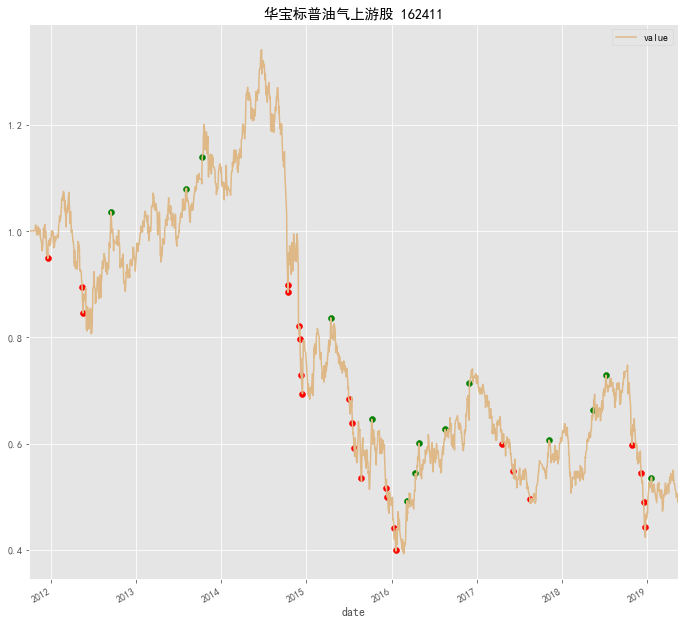

In [7]:
plt.close("all")
plt.figure()
plt.style.use("ggplot")
# sort_columns=True,
x = data.plot(
    x="date",
    y="value",
    color="burlywood",
    sort_columns=True,
    figsize=[7.75 * 1.5, 1.5 * 7.55],
)
plt.scatter(data.iloc[buy_x, 0], data.iloc[buy_x, 1], marker="o", color="r")
plt.scatter(data.iloc[sell_x, 0], data.iloc[sell_x, 1], marker="o", color="g")
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号
plt.title(get_name_new(162411, "name") + " 162411")

print(x)

In [4]:
def read(file):
    raw_data = pd.read_csv(
        file,
        delim_whitespace=True,
        names=["fund", "share", "cost"],
        dtype={"fund": str},
    )
    return raw_data

def lost(cost, value, share):
    return (value - cost) * share

In [36]:
name = os.getcwd() + "\\trade\\fund-cost.txt"
fund = read(name)
for index, row in fund.iterrows():
    fund_code = str(row["fund"])
    fund_name = os.getcwd() + "\\data\\" + fund_code + ".txt"
    tem = os.path.isfile(fund_name)
    today = time.strftime("%Y-%m-%d")


    if tem == False:
        fun_main(fund_code)
        print("down ", fund_name, os.path.isfile(fund_name))
    """
        if today != file_mdate(fund_name):
        open(fund_name, "w").close()
        fun_main(fund_code)
        print("update ", fund_name)
    """


    # read first row of data
    """
    tem = pd.read_csv(
        fund_name,
        names=["date", "value", "rvalue", "change"],
        delim_whitespace=True,
        nrows=1,
    )
    date = tem.iloc[0, 0]
    value = float(tem.iloc[0, 1])
    """
    value,date=update_value(fund_code)
    value=float(value)
    # read cost and share from trade/fund-cost.txt
    share = float(row["share"])
    cost = float(row["cost"])
    change = (value - cost) / value
    # print(share,cost,value)
    print(
        "{:25}{:8}{:<16} {:4.4f}  {:4.4%}".format(
            date,
            fund_code,
            get_name_new(fund_code, "name"),
            lost(cost, value, share),
            change,
        )
    )

2019-05-16 21:59         162411  华宝标普油气上游股        -9.0593  -2.1022%
2019-05-16 15:00         100038  富国沪深300指数增       -1.9907  -1.7616%
2019-05-16 15:00         161017  富国中证50           -8.8789  -6.2918%
2019-05-16 15:00         100032  富国中证红利指数增        -4.4732  -4.6890%
2019-05-16 15:00         004752  广发中证传媒ETF联接      -9.7546  -6.9554%
2019-05-16 15:00         003765  广发创业板ETF联接       -3.7006  -7.9931%
2019-05-16 15:00         000968  广发养老指数           -1.3676  -7.3396%
2019-05-16 15:00         001180  广发医药卫生联接         9.0808  6.0909%
substring not found
No Value                 000614  No Name          10153.0012  98.9282%
2019-05-16 21:57         000216  华安黄金易ETF联接       0.6340  0.3326%


In [35]:


def update_value(code):
    """
    Enter fund code
    return value and its time 
    get realtime value from base api 
    some fund may return none
    """
    api = "http://fundgz.1234567.com.cn/js/"
    # jsonpgz({"fundcode":"162411","name":"华宝标普油气上游股票",
    # "jzrq":"2019-05-10","dwjz":"0.5060","gsz":"0.4946","gszzl"
    #:"-2.24","gztime":"2019-05-14 04:00"})
    url = api + str(code) + ".js"
    gsz="gsz"
    gztime="gztime"
    base= '\"%s\":\"' 
    try:
        i = requests.get(url)
        sub = base % (gsz)
        name = find_str(i.text,sub,"\"")
        sub= base % (gztime)
        time= find_str(i.text,sub,"\"")
    except Exception as e:
        print(e)
        return 100,"No Value"
    finally:
        i.close()

    return name,time

def find_str(src,beginsrc,endsrc):
    """
    src beginsrc endsrc
    """
    begin=src.index(beginsrc)+len(beginsrc)
    end=src.index(endsrc,begin)
    return src[begin:end]



In [37]:
def get_fund_name(code):
    filename=".\\data\\funds_name.txt"
    with open(filename,'r') as file:
        for line in file:
            if line[0]==str(code):
                return line

In [42]:
%%prun
#get_fund_name("000614")
code="960042"
filename=".\\data\\funds_name.txt"
with open(filename,'r') as file:
    for line in file:
        if line[0]==str(code):
            print(line)